In [1]:
import os
import re
import cv2
import math
import string
import random
from glob import glob
from tqdm import tqdm
import numpy as np
from argparse import Namespace
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models

2023-04-17 22:54:51.297516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 22:54:51.501847: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-17 22:54:52.527878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2

2.10.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-17 22:54:53.728514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:54:53.743037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:54:53.743451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:54:53.744622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
NUM_JOINTS = 543

LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
#     78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
#     95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]

RIGHT_EYE = [
    246, 161, 160, 159, 158, 157, 173,
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    247, 30, 29, 27, 28, 56, 190,
    130, 25, 110, 24, 23, 22, 26, 112, 243,
    113, 225, 224, 223, 222, 221, 189,
    226, 31, 228, 229, 230, 231, 232, 233, 244,
    143, 111, 117, 118, 119, 120, 121, 128, 245,
]

LEFT_EYE = [
    466, 387, 386, 385, 384, 398,
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    467, 260, 259, 257, 258, 286, 414,
    359, 255, 339, 254, 253, 252, 256, 341, 463,
    342, 445, 444, 443, 442, 441, 413,
    446, 261, 448, 449, 450, 451, 452, 453, 464,
    372, 340, 346, 347, 348, 349, 350, 357, 465,
]

LEFT_HAND = [
    468, 469, 470, 471, 472, 473, 474, 475,
    476, 477, 478, 479, 480, 481, 482, 483,
    484, 485, 486, 487, 488
]

RIGHT_HAND = [
    522, 523, 524, 525, 526, 527, 528, 529,
    530, 531, 532, 533, 534, 535, 536, 537,
    538, 539, 540, 541, 542
]

POSE = [
    489, 490, 491, 492, 493, 494, 495, 496, 497,
    498, 499, 500, 501, 502, 503, 504, 505, 506,
    507, 508, 509, 510, 511, 512, 513, 514, 515,
    516, 517, 518, 519, 520, 521
]

In [4]:
def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = glob("../data/tfrecords/*.tfrec")
tfrecords = sorted(tfrecords, key=natural_keys)
print(tfrecords)

['../data/tfrecords/stratified_split_0.tfrec', '../data/tfrecords/stratified_split_1.tfrec', '../data/tfrecords/stratified_split_2.tfrec', '../data/tfrecords/stratified_split_3.tfrec', '../data/tfrecords/stratified_split_4.tfrec', '../data/tfrecords/stratified_split_5.tfrec', '../data/tfrecords/stratified_split_6.tfrec', '../data/tfrecords/stratified_split_7.tfrec', '../data/tfrecords/stratified_split_8.tfrec', '../data/tfrecords/stratified_split_9.tfrec', '../data/tfrecords/stratified_split_10.tfrec', '../data/tfrecords/stratified_split_11.tfrec', '../data/tfrecords/stratified_split_12.tfrec', '../data/tfrecords/stratified_split_13.tfrec', '../data/tfrecords/stratified_split_14.tfrec', '../data/tfrecords/stratified_split_15.tfrec', '../data/tfrecords/stratified_split_16.tfrec', '../data/tfrecords/stratified_split_17.tfrec', '../data/tfrecords/stratified_split_18.tfrec', '../data/tfrecords/stratified_split_19.tfrec', '../data/tfrecords/stratified_split_20.tfrec', '../data/tfrecords/str

In [33]:
def parse_sequence_raw(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.float32,
    )


def parse_tfrecord_fn(example):
    feature_description = {
        "n_frames": tf.io.FixedLenFeature([], tf.float32),
        "frames": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    
    return tf.io.parse_single_example(example, feature_description)


def parse_data(example):
    # Parse Frames
    n_frames = example["n_frames"]
    frames = tf.reshape(parse_sequence_raw(example["frames"]), shape=(n_frames, 543, 3))

    # Parse Labels
    label = example["label"]

    return n_frames, frames, label

AUTOTUNE = tf.data.AUTOTUNE


def get_dataloader(tfrecord):
    ds = tf.data.TFRecordDataset(tfrecord)

    dataloader = (
        ds
        .shuffle(1024)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(parse_data, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    
    return dataloader

In [6]:
def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.numpy()]))


def serialize_sequence(sequence):
    """Serialize the multidimentional tensor"""
    return tf.io.serialize_tensor(sequence)


def parse_sequence(serialized_sequence):
    return tf.io.parse_tensor(
        serialized_sequence,
        out_type=tf.uint8,
    )


def create_example(n_frames, sequence, label):
    feature = {
        "n_frames": float_feature(n_frames),
        "frames": bytes_feature(serialize_sequence(sequence)),
        "label": int64_feature(label),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [7]:
def generate_a_heatmap(arr, centers, max_values):
    """Generate pseudo heatmap for one keypoint in one frame.

    Args:
        arr (np.ndarray): The array to store the generated heatmaps. Shape: img_h * img_w.
        centers (np.ndarray): The coordinates of corresponding keypoints (of multiple persons). Shape: M * 2.
        max_values (np.ndarray): The max values of each keypoint. Shape: M.

    Returns:
        np.ndarray: The generated pseudo heatmap.
    """

    sigma = 0.1
    img_h, img_w = arr.shape

    for center, max_value in zip(centers, max_values):
        mu_x, mu_y = center[0], center[1]
        if not (np.isnan(mu_x) and np.isnan(mu_y)):
            # scale
            mu_x = min(math.floor(mu_x * img_w), img_w - 1)
            mu_y = min(math.floor(mu_y * img_h), img_h - 1)

            st_x = max(int(mu_x - 0.5 * sigma), 0)
            ed_x = min(int(mu_x + 0.5 * sigma) + 1, img_w)
            st_y = max(int(mu_y - 0.5 * sigma), 0)
            ed_y = min(int(mu_y + 0.5 * sigma) + 1, img_h)
            x = np.arange(st_x, ed_x, 1, np.float32)
            y = np.arange(st_y, ed_y, 1, np.float32)

            # if the keypoint not in the heatmap coordinate system
            if not (len(x) and len(y)):
                continue
            y = y[:, None]

            patch = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / 2 / sigma**2)
            patch = patch * max_value
            arr[st_y:ed_y, st_x:ed_x] = np.maximum(arr[st_y:ed_y, st_x:ed_x], patch)

In [8]:
def get_3d_heatmap(ret, human_kps, num_frames):
    
    for i, frame in enumerate(range(num_frames)):
        arr = ret[i]
        human = human_kps[i]

        x, y = human[:,:1], human[:,1:2]

        # TODO: Normalize the whole sequence together
        x = (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))
        y = (y-np.nanmin(y))/(np.nanmax(y)-np.nanmin(y))

        human = np.squeeze(np.array(list(zip(x, y))), axis=-1)

        kps = np.expand_dims(human, axis=0)
        all_kpscores = np.ones((1,num_frames,NUM_JOINTS), dtype=np.float32)
        kpscores = np.ones_like(all_kpscores[:, 0])

        num_kp = kps.shape[1]
        for i in range(num_kp):
            generate_a_heatmap(arr[i], kps[:, i], kpscores[:, i])

    return ret

In [9]:
def vis_heatmaps(heatmaps, channel=-1, ratio=8):
    # if channel is -1, draw all keypoints / limbs on the same map
    import matplotlib.cm as cm
    heatmaps = [x.transpose(1, 2, 0) for x in heatmaps]
    h, w, _ = heatmaps[0].shape
    newh, neww = int(h * ratio), int(w * ratio)

    if channel == -1:
        heatmaps = [np.max(x, axis=-1) for x in heatmaps]
    cmap = cm.viridis
    heatmaps = [(cmap(x)[..., :3] * 255).astype(np.uint8) for x in heatmaps]
    heatmaps = [cv2.resize(x, (neww, newh)) for x in heatmaps]
    return heatmaps

In [10]:
def draw_human_nodes(heatmap):
    keypoint_humans = []

    for arr in heatmap:
        keypoint_mapvis = vis_heatmaps(np.expand_dims(arr, axis=0), ratio=1)
        keypoint_humans.append(keypoint_mapvis[0])

    return np.array(keypoint_humans)

In [97]:
NUM_JOINTS = 107
IMG_H = 56
IMG_W = 56
tfrecords_dir = "../data/tfrecords_heatmaps_tmp"
os.makedirs(tfrecords_dir, exist_ok=True)

for idx, tfrecord in enumerate(tqdm(tfrecords, desc="TFRecords: ")):
    dataloader = get_dataloader(tfrecord)
    
    split = tfrecord.split("/")[-1].split(".")[0].split("_")[-1]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f"/split_{split}.tfrec"
    ) as writer:

        for idx, (num_frames, data, label) in enumerate(tqdm(dataloader, desc=f"Reading TFRecord idx: {split}")):
            faces = tf.gather(data, LIP, axis=1).numpy()
            poses = tf.gather(data, POSE, axis=1).numpy()[:,:-8]
            rhs = tf.gather(data, RIGHT_HAND, axis=1).numpy()
            lhs = tf.gather(data, LEFT_HAND, axis=1).numpy()

            humans = np.concatenate([faces, poses, rhs, lhs], axis=1)
            num_frames = humans.shape[0]
            print(num_frames)
            
            if num_frames < 32:
                humans = tf.image.resize(humans, (32,87), method="nearest").numpy()
            else:
                # uniform sampling
                indices = sorted(np.random.choice(num_frames, 32, replace=False))
                humans = humans[indices]

            num_frames = humans.shape[0]
            ret = np.zeros([num_frames, NUM_JOINTS, IMG_H, IMG_W], dtype=np.float32)

            heatmap = get_3d_heatmap(ret, humans, num_frames)

            keypoint_humans = draw_human_nodes(heatmap)

            example = create_example(
                num_frames,
                keypoint_humans,
                label.numpy()
            )

            writer.write(example.SerializeToString())

            break

    break

TFRecords:   0%|                                                  | 0/24 [00:00<?, ?it/s]
Reading TFRecord idx: 0: 0it [00:00, ?it/s]
TFRecords:   0%|                                                  | 0/24 [00:00<?, ?it/s]

55


In [98]:
tfrec_path = tfrecords_dir + "/split_0.tfrec"
raw_dataset = tf.data.TFRecordDataset(tfrec_path)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [99]:
example = parse_tfrecord_fn(next(iter(raw_dataset)))

In [100]:
example["n_frames"]

<tf.Tensor: shape=(), dtype=float32, numpy=32.0>

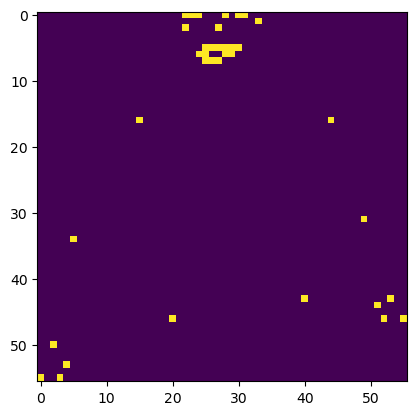

In [101]:
plt.imshow(tf.reshape(parse_sequence(example["frames"]), shape=(example["n_frames"], 56, 56, 3)).numpy()[7])

In [102]:
tf.reshape(parse_sequence(example["frames"]), shape=(example["n_frames"], 56, 56, 3)).numpy().shape

(32, 56, 56, 3)

In [103]:
fig, ax = plt.subplots(figsize=(5, 8))

arr = tf.reshape(parse_sequence(example["frames"]), shape=(example["n_frames"], 56, 56, 3)).numpy()

def update(i):
    im_normed = arr[i]
    ax.imshow(im_normed)
    ax.set_title(f"human_{i}", fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, len(arr)), interval=10)
anim.save('humanpose3d-resized1.gif', dpi=80, writer='imagemagick')
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.
